In [1]:
import numpy as np
import pandas as pd
import quandl
import datetime
import matplotlib.pyplot as plt

In [2]:
start = datetime.datetime(2010,1,1)
end = datetime.date.today()


In [3]:
quandl.ApiConfig.api_key = 'xE6hSTRjfcDRnFScKkz-'
apple, microsoft, google, facebook, twitter, netflix, amazon = (quandl.get("WIKI/" + s, start_date=start, end_date=end) for s in ["AAPL", "MSFT", "GOOG", "FB", "TWTR", "NFLX", "AMZN"])

In [4]:
stocks = pd.DataFrame({"AAPL": apple["Adj. Close"],
                       "MSFT": microsoft["Adj. Close"],
                       "GOOG": google["Adj. Close"],
                       "FB": facebook["Adj. Close"],
                       "TWTR": twitter["Adj. Close"],
                       "NFLX": netflix["Adj. Close"],
                       "AMZN": amazon["Adj. Close"]
                      })
 

In [5]:
stocks.head()

,AAPL,MSFT,GOOG,FB,TWTR,NFLX,AMZN
Date,,,,,,,
2010-01-04,27.503268,25.153472,NaN,NaN,NaN,7.640000,133.90
2010-01-05,27.550818,25.161599,NaN,NaN,NaN,7.358571,134.69
2010-01-06,27.112585,25.007183,NaN,NaN,NaN,7.617143,132.25
2010-01-07,27.062465,24.748741,NaN,NaN,NaN,7.485714,130.00
2010-01-08,27.242385,24.917785,NaN,NaN,NaN,7.614286,133.52


<Figure size 1008x504 with 0 Axes>

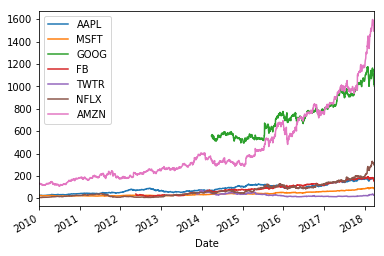

In [6]:
plt.figure(figsize=(14, 7))
stocks.plot()


In [7]:
import numpy as np
 
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) 
stock_change.head()

,AAPL,MSFT,GOOG,FB,TWTR,NFLX,AMZN
Date,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.001727,0.000323,NaN,NaN,NaN,-0.037532,0.005883
2010-01-06,-0.016034,-0.006156,NaN,NaN,NaN,0.034536,-0.018282
2010-01-07,-0.001850,-0.010389,NaN,NaN,NaN,-0.017405,-0.017160
2010-01-08,0.006626,0.006807,NaN,NaN,NaN,0.017030,0.026717


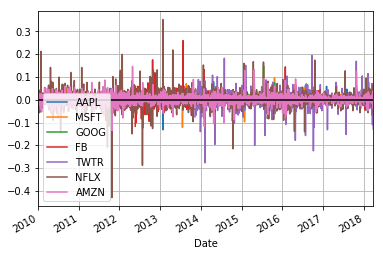

In [8]:
stock_change.plot(grid = True).axhline(y = 0, color = "black")

In [9]:
def strategy(stocks, fast, slow):
    
    fast_str = str(fast) + 'd'
    slow_str = str(slow) + 'd'
    ma_diff_str = fast_str + '-' + slow_str
 
    trades = pd.DataFrame({"Price": [], "Regime": [], "Signal": []})
    
    for s in stocks:
        s[1][fast_str] = np.round(s[1]["Close"].rolling(window = fast, center = False).mean(), 2)
        s[1][slow_str] = np.round(s[1]["Close"].rolling(window = slow, center = False).mean(), 2)
        s[1][ma_diff_str] = s[1][fast_str] - s[1][slow_str]
 
        s[1]["Regime"] = np.where(s[1][ma_diff_str] > 0, 1, 0)
        s[1]["Regime"] = np.where(s[1][ma_diff_str] < 0, -1, s[1]["Regime"])
        regime_orig = s[1].loc[:, "Regime"].iloc[-1]
        s[1].loc[:, "Regime"].iloc[-1] = 0
        s[1]["Signal"] = np.sign(s[1]["Regime"] - s[1]["Regime"].shift(1))
        s[1].loc[:, "Regime"].iloc[-1] = regime_orig
 
        signals = pd.concat([
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == 1, "Adj. Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == 1, "Regime"],
                         "Signal": "Buy"}),
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == -1, "Adj. Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == -1, "Regime"],
                         "Signal": "Sell"}),
        ])
        signals.index = pd.MultiIndex.from_product([signals.index, [s[0]]], names = ["Date", "Symbol"])
        trades = trades.append(signals)
 
    trades.sort_index(inplace = True)
    trades.index = pd.MultiIndex.from_tuples(trades.index, names = ["Date", "Symbol"])
 
    return trades
 
 

In [10]:
def backtest(signals, cash, port_value = .1, batch = 100):
   
 
    SYMBOL = 1 
    portfolio = dict()
    port_prices = dict()
    short_dict=dict()
    results = pd.DataFrame({"Start Cash": [],
                            "End Cash": [],
                            "Portfolio Value": [],
                            "Type": [],
                            "Shares": [],
                            "Share Price": [],
                            "Trade Value": [],
                            "Profit per Share": [],
                            "Total Profit": [],
                            "Shorted Val": []})
 
    for index, row in signals.iterrows():
        shares = portfolio.setdefault(index[SYMBOL], 0)
        short_shares= short_dict.setdefault(index[SYMBOL], 0)
        trade_val = 0
        short_val=0
        batches = 0
        cash_change = row["Price"] * shares   
        portfolio[index[SYMBOL]] = 0 
        
        old_price = port_prices.setdefault(index[SYMBOL], row["Price"])
        portfolio_val = 0
        for key, val in portfolio.items():
            portfolio_val += val * port_prices[key]
 
        if row["Signal"] == "Buy" and row["Regime"] == 1: 
            batches = np.floor((portfolio_val + cash) * port_value) // np.ceil(batch * row["Price"])
            trade_val = batches * batch * row["Price"] 
            cash_change -= trade_val 
            portfolio[index[SYMBOL]] = batches * batch 
            short_dict[index[SYMBOL]] = batches * batch 
            port_prices[index[SYMBOL]] = row["Price"]  
            old_price = row["Price"]
        elif row["Signal"] == "Sell" and row["Regime"] == -1:
            shortsell = short_dict[index[SYMBOL]]*row["Price"]          
            short_val = shortsell
            
            
        
        pprofit = row["Price"] - old_price   
 
        
        results = results.append(pd.DataFrame({
                "Start Cash": cash,
                "End Cash": cash + cash_change,
                "Portfolio Value": cash + cash_change + portfolio_val + trade_val + short_val,
                "Type": row["Signal"],
                "Shares": short_dict[index[SYMBOL]],
                "Share Price": row["Price"],
                "Trade Value": abs(cash_change),
                "Profit per Share": pprofit,
                "Total Profit": batches * batch * pprofit,
                "Shorted Val": short_val
            }, index = [index]))
        cash += cash_change  
 
    results.sort_index(inplace = True)
    results.index = pd.MultiIndex.from_tuples(results.index, names = ["Date", "Symbol"])
 
    return results

In [11]:
signals = strategy([("AAPL", apple),
                    ("MSFT",  microsoft),
                    ("GOOG",  google),
                    ("FB",  facebook),
                    ("TWTR",  twitter),
                    ("NFLX",  netflix),
                    ("AMZN",  amazon)],
                     fast = 20, slow = 50)

signals


/home/gaurav/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Price  Regime Signal
Date       Symbol                            
2010-03-16 AAPL      28.844953     1.0    Buy
           AMZN     131.790000     1.0    Buy
           MSFT      23.978839    -1.0   Sell
           NFLX      10.090000     1.0    Buy
2010-03-24 MSFT      24.207442     1.0    Buy
2010-05-19 AMZN     124.590000    -1.0   Sell
           MSFT      23.161072    -1.0   Sell
2010-06-11 AAPL      32.579568    -1.0   Sell
2010-06-18 AAPL      35.222329     1.0    Buy
2010-07-22 AAPL      33.288194    -1.0   Sell
2010-07-29 NFLX      14.002857    -1.0   Sell
2010-08-03 MSFT      21.455158     1.0    Buy
2010-08-06 AMZN     128.320000     1.0    Buy
2010-08-23 NFLX      18.128571     1.0    Buy
2010-08-25 MSFT      19.869634     0.0   Sell
2010-08-26 MSFT      19.638783    -1.0   Sell
2010-09-20 AAPL      36.399003     1.0    Buy
2010-10-07 MSFT      20.224154     1.0    Buy
2011-01-24 NFLX      26.280000    -1.0   Sell
2011-01-27 NFLX      30.124286     1.0    Buy
2011-02-07 AMZN     176.430000    -1.0   Sell
2011-02-16 MSFT      22.548201    -1.0   Sell
2011-03-21 NFLX      30.405714    -1.0   Sell
2011-03-29 NFLX      33.911429     1.0    Buy
2011-03-30 AAPL      44.803814     0.0   Sell
2011-03-31 AAPL      44.788071    -1.0   Sell
2011-04-14 AMZN     181.820000     1.0    Buy
2011-05-02 MSFT      21.413281     0.0    Buy
2011-05-03 MSFT      21.538456     1.0    Buy
2011-05-12 AAPL      44.539075     1.0    Buy
...                        ...     ...    ...
2017-06-30 NFLX     149.410000    -1.0   Sell
2017-07-07 GOOG     918.590000    -1.0   Sell
2017-07-17 TWTR      19.940000     1.0    Buy
2017-07-21 NFLX     188.540000     1.0    Buy
2017-08-02 AAPL     156.504989     1.0    Buy
2017-08-11 TWTR      15.920000    -1.0   Sell
2017-08-22 AMZN     966.900000    -1.0   Sell
2017-09-22 TWTR      17.610000     0.0    Buy
2017-09-25 TWTR      16.980000     1.0    Buy
2017-09-28 GOOG     949.500000     1.0    Buy
2017-10-02 AAPL     153.810000    -1.0   Sell
2017-10-16 AMZN    1006.340000     1.0    Buy
2017-11-01 AAPL     166.890000     1.0    Buy
2017-12-06 NFLX     185.300000    -1.0   Sell
2017-12-26 FB       175.990000    -1.0   Sell
2018-01-03 FB       184.670000     1.0    Buy
2018-01-09 NFLX     209.310000     1.0    Buy
2018-02-06 AAPL     163.030000    -1.0   Sell
2018-02-23 FB       183.290000    -1.0   Sell
2018-02-27 GOOG    1118.290000    -1.0   Sell
2018-03-08 AAPL     176.940000     1.0    Buy
2018-03-14 GOOG    1149.490000     1.0    Buy
2018-03-23 GOOG    1021.570000    -1.0   Sell
2018-03-27 AAPL     168.340000     1.0   Sell
           AMZN    1497.050000     1.0   Sell
           FB       152.190000    -1.0    Buy
           GOOG    1005.100000    -1.0    Buy
           MSFT      89.470000     1.0   Sell
           NFLX     300.690000     1.0   Sell
           TWTR      28.070000     1.0   Sell

[262 rows x 3 columns]

In [12]:
bk = backtest(signals, 1000000)
bk

Start Cash      End Cash  Portfolio Value  Type   Shares  \
Date       Symbol                                                               
2010-03-16 AAPL    1.000000e+06  9.019272e+05     1.000000e+06   Buy   3400.0   
           AMZN    9.019272e+05  8.096742e+05     1.000000e+06   Buy    700.0   
           MSFT    8.096742e+05  8.096742e+05     1.000000e+06  Sell      0.0   
           NFLX    8.096742e+05  7.097832e+05     1.000000e+06   Buy   9900.0   
2010-03-24 MSFT    7.097832e+05  6.105326e+05     1.000000e+06   Buy   4100.0   
2010-05-19 AMZN    6.105326e+05  6.977456e+05     1.082173e+06  Sell    700.0   
           MSFT    6.977456e+05  7.927060e+05     1.085630e+06  Sell   4100.0   
2010-06-11 AAPL    7.927060e+05  9.034766e+05     1.114138e+06  Sell   3400.0   
2010-06-18 AAPL    9.034766e+05  8.048541e+05     1.003368e+06   Buy   2800.0   
2010-07-22 AAPL    8.048541e+05  8.980610e+05     1.091159e+06  Sell   2800.0   
2010-07-29 NFLX    8.980610e+05  1.036689e+06     1.175318e+06  Sell   9900.0   
2010-08-03 MSFT    1.036689e+06  9.337045e+05     1.036689e+06   Buy   4800.0   
2010-08-06 AMZN    9.337045e+05  8.310485e+05     1.036689e+06   Buy    800.0   
2010-08-23 NFLX    8.310485e+05  7.277157e+05     1.036689e+06   Buy   5700.0   
2010-08-25 MSFT    7.277157e+05  8.230899e+05     1.029079e+06  Sell   4800.0   
2010-08-26 MSFT    8.230899e+05  8.230899e+05     1.123345e+06  Sell   4800.0   
2010-09-20 AAPL    8.230899e+05  7.211727e+05     1.029079e+06   Buy   2800.0   
2010-10-07 MSFT    7.211727e+05  6.200519e+05     1.029079e+06   Buy   5000.0   
2011-01-24 NFLX    6.200519e+05  7.698479e+05     1.225338e+06  Sell   5700.0   
2011-01-27 NFLX    7.698479e+05  6.644129e+05     1.075542e+06   Buy   3500.0   
2011-02-07 AMZN    6.644129e+05  8.055569e+05     1.255174e+06  Sell    800.0   
2011-02-16 MSFT    8.055569e+05  9.182979e+05     1.238391e+06  Sell   5000.0   
2011-03-21 NFLX    9.182979e+05  1.024718e+06     1.233055e+06  Sell   3500.0   
2011-03-29 NFLX    1.024718e+06  9.128102e+05     1.126635e+06   Buy   3300.0   
2011-03-30 AAPL    9.128102e+05  1.038261e+06     1.150169e+06  Sell   2800.0   
2011-03-31 AAPL    1.038261e+06  1.038261e+06     1.275575e+06  Sell   2800.0   
2011-04-14 AMZN    1.038261e+06  9.291689e+05     1.150169e+06   Buy    600.0   
2011-05-02 MSFT    9.291689e+05  9.291689e+05     1.150169e+06   Buy   5000.0   
2011-05-03 MSFT    9.291689e+05  8.150151e+05     1.150169e+06   Buy   5300.0   
2011-05-12 AAPL    8.150151e+05  7.036674e+05     1.150169e+06   Buy   2500.0   
...                         ...           ...              ...   ...      ...   
2017-06-30 NFLX    9.523142e+05  1.206311e+06     2.119190e+06  Sell   1700.0   
2017-07-07 GOOG    1.206311e+06  1.390029e+06     2.060077e+06  Sell    200.0   
2017-07-17 TWTR    1.390029e+06  1.202593e+06     1.876359e+06   Buy   9400.0   
2017-07-21 NFLX    1.202593e+06  1.032907e+06     1.876359e+06   Buy    900.0   
2017-08-02 AAPL    1.032907e+06  8.607517e+05     1.876359e+06   Buy   1100.0   
2017-08-11 TWTR    8.607517e+05  1.010400e+06     1.988219e+06  Sell   9400.0   
2017-08-22 AMZN    1.010400e+06  1.203780e+06     2.065947e+06  Sell    200.0   
2017-09-22 TWTR    1.203780e+06  1.203780e+06     1.872567e+06   Buy   9400.0   
2017-09-25 TWTR    1.203780e+06  1.017000e+06     1.872567e+06   Buy  11000.0   
2017-09-28 GOOG    1.017000e+06  9.220497e+05     1.872567e+06   Buy    100.0   
2017-10-02 AAPL    9.220497e+05  1.091241e+06     2.038794e+06  Sell   1100.0   
2017-10-16 AMZN    1.091241e+06  9.906067e+05     1.869603e+06   Buy    100.0   
2017-11-01 AAPL    9.906067e+05  8.070277e+05     1.869603e+06   Buy   1100.0   
2017-12-06 NFLX    8.070277e+05  9.737977e+05     2.033457e+06  Sell    900.0   
2017-12-26 FB      9.737977e+05  1.202585e+06     2.159655e+06  Sell   1300.0   
2018-01-03 FB      1.202585e+06  1.017915e+06     1.930868e+06   Buy   1000.0   
2018-01-09 NFLX    1.017915e+06  8.295357e+05     1.

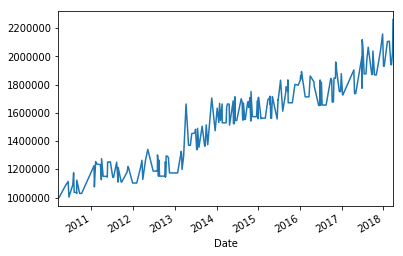

In [13]:
bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]).plot()